# Calculate GSFE

### This script will use mdapy to calculate the generalized stacking fault energy directly

In [1]:
import mdapy as mp
import polars as pl
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
mp.init()

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.10.0
[Taichi] Starting on arch=x64


In [2]:
mp.__version__

'0.9.5'

### Generate a FCC lattice with orientation x[11-2], y[1-10] and z[111]

In [3]:
lattice_constant = 4.05
lattice_type = 'FCC'

In [4]:
fcc = mp.LatticeMaker(lattice_constant, lattice_type, 10, 15, 10, crystalline_orientation=np.array([[1, 1, -2], [1, -1, 0], [1, 1, 1]]))
fcc.compute()

In [5]:
system = mp.System(pos=fcc.pos, box=fcc.box)

### Change boundary condition to free along z axis

In [6]:
system.boundary[-1] = 0

### Calculate the initial potential energy

In [7]:
system.cal_energy_force('../../../example/Al_DFT.eam.alloy', ['Al'], max_neigh=150)

In [8]:
pe0 = system.data['pe'].sum()

In [9]:
move = (lattice_constant/6**0.5+0.2)/50
factor = system.box[0,0]* system.box[1,1]/16021.766200000002

### Calculate the GSFE along [112] direction

In [10]:
sfe = [0.]
for i in tqdm(range(1, 51)):
    # newdata = system.data.with_columns(pl.when(pl.col('z')>35).then(pl.col('x')+move).otherwise(pl.col('x')).alias('x'))
    # system.update_data(newdata,update_pos=True) # Move the upper part.
    system.data.replace('x', system.data.select(pl.when(pl.col('z')>35).then(pl.col('x')+move).otherwise(pl.col('x'))).to_series()) # Move the upper part.
    system.update_pos()
    system.wrap_pos() # Wrap the positions
    system.if_neigh = False # Make sure rebuild neighbor every time
    system.cal_energy_force('../../../example/Al_DFT.eam.alloy', ['Al'], max_neigh=150)
    sfe.append((system.data['pe'].sum()-pe0)/factor)

100%|██████████| 50/50 [00:08<00:00,  5.69it/s]


### Plot the results

In [11]:
mp.pltset()

Text(0.97, 25, 'ISF')

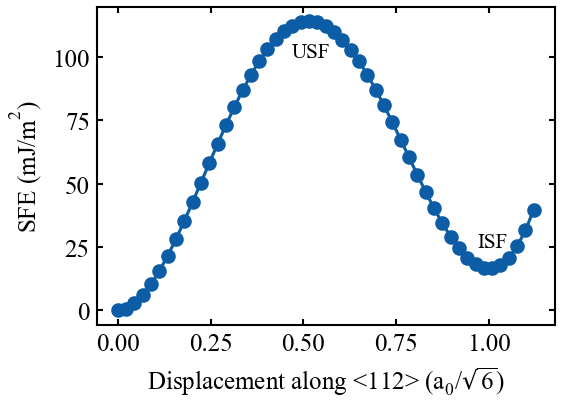

In [12]:
fig = plt.figure(figsize=(mp.cm2inch(10), mp.cm2inch(7)), dpi=150)
plt.plot(np.arange(51)*move/(lattice_constant/6**0.5), sfe, 'o-')
plt.xlabel(r"Displacement along <112> " + "$\mathregular{(a_0/\sqrt{6})}$")
plt.ylabel("SFE ($\mathregular{mJ/{m^2}}$)")
plt.text(0.47, 100, 'USF')
plt.text(0.97, 25, 'ISF')